## Vector store, vector database, index and document stores

This notebook explores vector stores, index, metadata and persistence using FAISS and Qdrant, and aims at underlying the difference between these concepts.

When dealing with RAGs, both the **embeddings** and the corresponding **chunks** of text must be stored (together with metadata, sometimes). Therefore, both a **vector store** (to store the embeddings or dense vectors) and a **document store** (to store the chunk of text and their corresponding metadata) are required.

The last important piece of the puzzle is the **index**. In data engineering, an index refers to a data structure that improves the speed of data retrieval operations, at the cost of additional writes and storage space. Pretty much like the index of a book, that allows you to find the information you need without having to go through all the pages of the book, the index in a database allows the user to fetch the information needed without having to go through all the data stored. When it comes to index of embeddings, sometimes the index is separated from the store of embedings, but not always.

Some vector stores might offer to store everything, but some other vector stores might not. The original FAISS library from Facebook, for example, does not store the text (however, the langchain implementation adds a wrapper which allows storing the text).

So, we have the following concepts (Vector Store, VectorDB, Document Store and Index) which are used interchangeably, but refer to very specific part of the storage and retreival process. This notebook attempts at clarifying these.

So, to summarize:
1. Three core components: vector store, document store, index
1. Vector stores contain the embeddings
2. Document stores contain the chunks of text and the metadata
3. Sometimes, but it's not always the case, a vector store can contain both
4. An index is a data structure that helps retrieve embeddings faster
5. An index may or may not also store the embeddings



## Persistence and Vector Stores/Vector Database

The concepts of **Vector Stores** and **Vector Database** both convey the idea that the vectors which are stored in them are here to stay.

But this is wrong.

Some of these vector stores exist **in memory** only, which means that, at the end of the session that created them, they disapear, and all the data in them is lost.

**Persistence** is the ability of a vector store to be retreived and used in a new session. Generally, 2 options exist: persistence via a database (in the cloud or locally), and / or via a file.

If persisting your embeddings, chunks, metata and index is important, then it's important to check that the vector store of your chosing offers 'persistence' options, and which ones.

Make sure that you run these cells to load the text that will be used in the examples below, as well as the OpenAI API key.

## Dependencies and text

In [ ]:
!wget https://frontiernerds.com/files/state_of_the_union.txt -O state_of_the_union.txt

--2024-08-26 10:57:14--  https://frontiernerds.com/files/state_of_the_union.txt
Resolving frontiernerds.com (frontiernerds.com)... 172.67.180.189, 104.21.31.232, 2606:4700:3036::6815:1fe8, ...
Connecting to frontiernerds.com (frontiernerds.com)|172.67.180.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘state_of_the_union.txt’

state_of_the_union.     [ <=>                ]  39.91K  --.-KB/s    in 0.01s   

2024-08-26 10:57:14 (3.44 MB/s) - ‘state_of_the_union.txt’ saved [40864]



In [ ]:
from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

## FAISS

What is FAISS? From the FAISS documentation:

> Facebook AI Similarity Search (Faiss) is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM. It also contains supporting code for evaluation and parameter tuning.



By definition, **FAISS is an index first, rather than a vector store**. It's primary purpose isn't to store embedings and the corresponding documents, it is to offer an efficient way to run similarity search.

As we will show here, the only way to persist FAISS is via files on the local hard drive. If you need a database that would allow multiple concurent connections, partial updates or deletion, or persistence beyond the current session, FAISS is not your guy.

However, if you have a set of vectors and need to find an efficient way of running similarity search amongst them, then FAISS is a great option.

### In memory

Install all required packages:

In [ ]:
!pip install -qU langchain-community faiss-cpu langchain-openai tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 322.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.9/394.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.

Get a text, split it, create the embeddings, and generate the index.

In [ ]:
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = TextLoader("state_of_the_union.txt")
documents = loader.load()
print(documents)

[Document(metadata={'source': 'state_of_the_union.txt'}, page_content='Madame Speaker, Vice President Biden, members of Congress, distinguished guests, and fellow Americans:\n\nOur Constitution declares that from time to time, the president shall give to Congress information about the state of our union. For 220 years, our leaders have fulfilled this duty. They have done so during periods of prosperity and tranquility. And they have done so in the midst of war and depression; at moments of great strife and great struggle.\n\nIt\'s tempting to look back on these moments and assume that our progress was inevitable, that America was always destined to succeed. But when the Union was turned back at Bull Run and the Allies first landed at Omaha Beach, victory was very much in doubt. When the market crashed on Black Tuesday and civil rights marchers were beaten on Bloody Sunday, the future was anything but certain. These were times that tested the courage of our convictions and the strength 

LangChain `document_loaders` generate Document objects, made of two attributes: `page_content` and `metadata`.

The `metadata` dictionnary can be updated to include whatever metadata you see fit to add.

When a splitter is applied to a document, the existing metadata are attached to all the chunks and a list of new `Document` objects is returned.

In [ ]:
# Adding a random metadata to show it's replicated to all the chunks
documents[0].metadata.update({"New_metadata":"26-08-2024"})
# Apply a splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

As we can see, the new metadata is still there.

In [ ]:
docs[5]

Document(metadata={'source': 'state_of_the_union.txt', 'New_metadata': '26-08-2024'}, page_content='One year ago, I took office amid two wars, an economy rocked by severe recession, a financial system on the verge of collapse and a government deeply in debt. Experts from across the political spectrum warned that if we did not act, we might face a second depression. So we acted immediately and aggressively. And one year later, the worst of the storm has passed.')

Now, the `Document` objects (text and metadata) can be added to the vector database.

In [ ]:
embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(docs, embeddings)
print(db.index.ntotal)

146


The vector store can then be queried to find the most similar embeddings to the query:

In [ ]:
query = "What did the president say about the challenges ahead?"
docs = db.similarity_search(query)
print("\n***\n".join([str(_) for _ in docs]))

page_content='From the day I took office, I have been told that addressing our larger challenges is too ambitious -- that such efforts would be too contentious, that our political system is too gridlocked and that we should just put things on hold for a while.

For those who make these claims, I have one simple question:

How long should we wait? How long should America put its future on hold?' metadata={'source': 'state_of_the_union.txt', 'New_metadata': '26-08-2024'}
***
page_content='And tonight, I'd like to talk about how together, we can deliver on that promise.

It begins with our economy.' metadata={'source': 'state_of_the_union.txt', 'New_metadata': '26-08-2024'}
***
page_content='reject the false choice between protecting our people and upholding our values. Let's leave behind the fear and division and do what it takes to defend our nation and forge a more hopeful future -- for America and the world.' metadata={'source': 'state_of_the_union.txt', 'New_metadata': '26-08-2024'}


In [ ]:
docs_with_scores = db.similarity_search_with_score(query)
print("Number of elements returned: ", len(docs_with_scores))
print("Type of 'docs_scores[0]': ", type(docs_with_scores[0]))

Number of elements returned:  4
Type of 'docs_scores[0]':  <class 'tuple'>


Let's explore the different Documents returned, with their score:

In [ ]:
for doc in docs_with_scores:
  print("***")
  print("Page content: \n'", doc[0].page_content, "'")
  print("Score: ", doc[1])

***
Page content: 
' From the day I took office, I have been told that addressing our larger challenges is too ambitious -- that such efforts would be too contentious, that our political system is too gridlocked and that we should just put things on hold for a while.

For those who make these claims, I have one simple question:

How long should we wait? How long should America put its future on hold? '
Score:  0.31473178
***
Page content: 
' And tonight, I'd like to talk about how together, we can deliver on that promise.

It begins with our economy. '
Score:  0.35198262
***
Page content: 
' reject the false choice between protecting our people and upholding our values. Let's leave behind the fear and division and do what it takes to defend our nation and forge a more hopeful future -- for America and the world. '
Score:  0.35654485
***
Page content: 
' So we face big and difficult challenges. And what the American people hope what they deserve is for all of us, Democrats and Republica

The elements with the lowest score are returned.

### On file

Now we can save the FAISS index locally (local drive) and see how it is saved.

In [ ]:
# Save the faiss index locally
db.save_local("faiss_index")

Saving locally gives us two files which make up the index, and contains the embeddings and an additional payload corresponding to the text chunks. This is nice add-on from the LangChain implementation of FAISS.

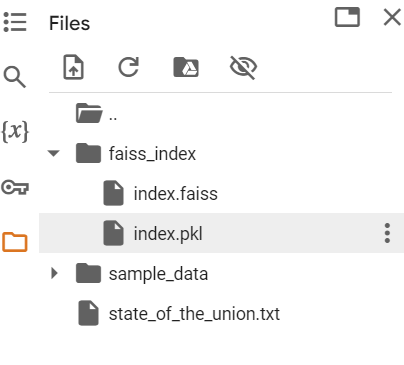

Once saved locally, we can load it from the local files, and resume our work.

In [ ]:
new_db = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

docs = new_db.similarity_search(query)

print(docs[0].page_content)

From the day I took office, I have been told that addressing our larger challenges is too ambitious -- that such efforts would be too contentious, that our political system is too gridlocked and that we should just put things on hold for a while.

For those who make these claims, I have one simple question:

How long should we wait? How long should America put its future on hold?


Without the possibility of persisting the FAISS index with the embedding, the chunks of text and the metadata, all the work of splitting the documents into chunks and creating the embeddings would need to be done again at the next session.

## Qdrant

**Qdrant** (read: quadrant) is a vector similarity **search engine and store**. It manages vectors with additional payload, and allow storage of embeddings, text and metadata. Three modes are available:

* Local mode, no server required (either on file or in memory)

* On-premise server deployment

* Qdrant Cloud

In [ ]:
%pip install -qU  langchain-qdrant langchain-openai langchain langchain-community

Please note that with LangChain 0.2 `langchain_community.vectorstores.qdrant.Qdrant` is depracated, and `langchain_qdrant.Qdrant` should be used instead.

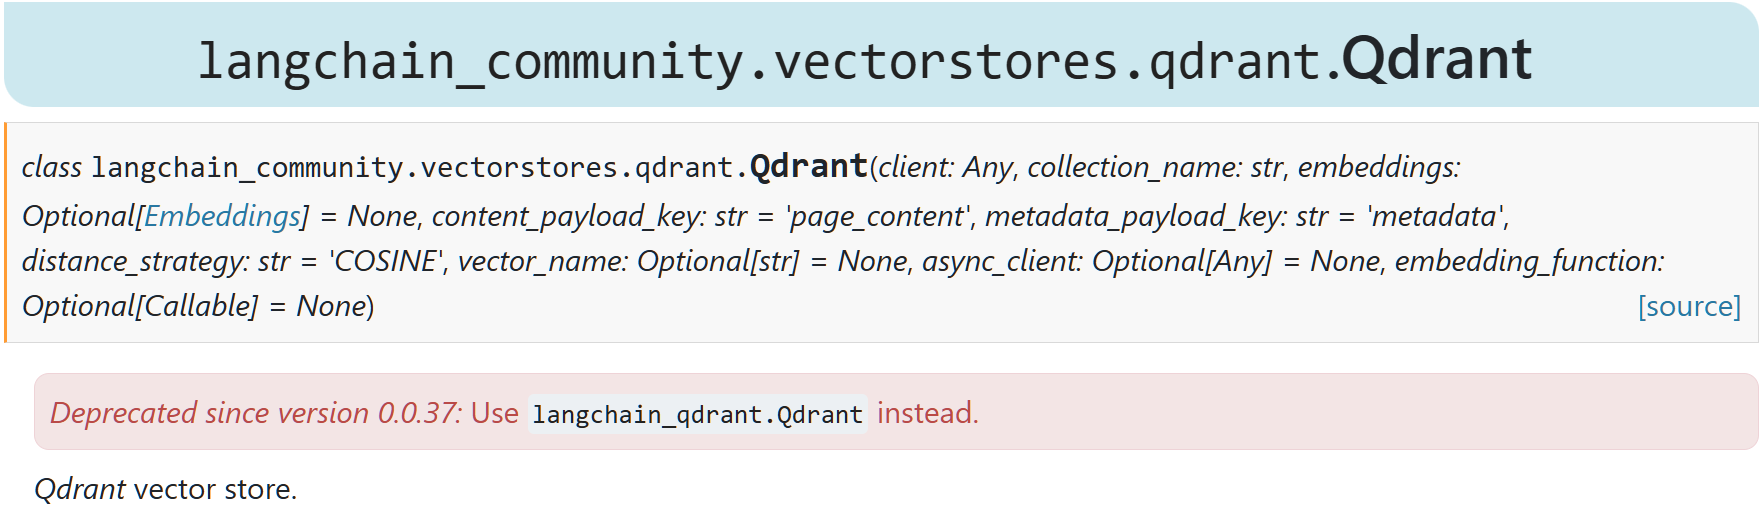

In [ ]:
from langchain_community.document_loaders import TextLoader
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import Qdrant
from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter

loader = TextLoader("state_of_the_union.txt")
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

embeddings = OpenAIEmbeddings()

Let's test in memory and local file storage.

### In memory

In [ ]:
qdrant = Qdrant.from_documents(
    docs,
    embedding=embeddings,
    location=":memory:",  # Local mode with in-memory storage only
    collection_name="my_documents",
)

Note that, with Qdrant, when you specify an embedding, you automaticall select the retreival mode as dense (similarity search based on dense vectors). The code above is the same as:
```
from langchain_qdrant import RetrievalMode

qdrant = Qdrant.from_documents(
    docs,
    embedding=embeddings,
    location=":memory:",  # Local mode with in-memory storage only
    collection_name="my_documents",
    retrieval_mode=RetrievalMode.DENSE,
)

```



In [ ]:
query = "What did the president say about the challenges ahead"
returned_docs = qdrant.similarity_search(query)
print(returned_docs[0].page_content)

From the day I took office, I have been told that addressing our larger challenges is too ambitious -- that such efforts would be too contentious, that our political system is too gridlocked and that we should just put things on hold for a while.

For those who make these claims, I have one simple question:

How long should we wait? How long should America put its future on hold?


In [ ]:
docs_with_scores = qdrant.similarity_search_with_score(query)

for doc in docs_with_scores:
  print("***")
  print("Page content: \n'", doc[0].page_content, "'")
  print("Score: ", doc[1])

***
Page content: 
' From the day I took office, I have been told that addressing our larger challenges is too ambitious -- that such efforts would be too contentious, that our political system is too gridlocked and that we should just put things on hold for a while.

For those who make these claims, I have one simple question:

How long should we wait? How long should America put its future on hold? '
Score:  0.8354617567415253
***
Page content: 
' And tonight, I'd like to talk about how together, we can deliver on that promise.

It begins with our economy. '
Score:  0.8287524616653091
***
Page content: 
' reject the false choice between protecting our people and upholding our values. Let's leave behind the fear and division and do what it takes to defend our nation and forge a more hopeful future -- for America and the world. '
Score:  0.8279235883233353
***
Page content: 
' London to reaffirm our common purpose. There will be difficult days ahead. But I am confident we will succeed.

As you can see, when working with Qdrant, the piece of text (chunk) with the highest score is selected, whereas when working with FAISS the piece of text with the lowest score was selected.

### Adding Hybrid search

If you want to use Hybrid search (similarity search + keyword search), you can do so by:
1. Specifying an implementation of `SparseEmbeddings` for attribute `sparse_embedding`
2. Specifying `retrieval_mode` as HYBRID.

```
from langchain_qdrant import FastEmbedSparse, RetrievalMode

sparse_embeddings = FastEmbedSparse(model_name="Qdrant/bm25")

qdrant = QdrantVectorStore.from_documents(
    docs,
    sparse_embedding=sparse_embeddings,
    embedding=embeddings,
    location=":memory:",
    collection_name="my_documents",
    retrieval_mode=RetrievalMode.HYBRID,
)
```

⚡⚡⚡ As you can see, the type of retrieval must be specified when the vector store is created. This is because this choice impacts how the index will be built. Once this is decided, there is no going back. If you want to change the type of retrieval, you will need to create a new vector store and populate it from scratch.

### On file

To use Qdrant with file persistence, use the `path` attribute.

In [ ]:
qdrant = Qdrant.from_documents(
    docs,
    embeddings,
    path="qdrant",
    collection_name="my_documents",
)

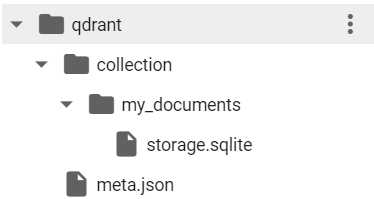

When the `path` argument is present, a local file is created (sqlite file) to persist the index, embeddings and documents.

It is interesting to note that sqlite is a file-based database. So, qdrant does persist the data locally using a file, but it's a database. This means that concurrent access (read and write) are possible and managed to a certain extent (sqlite is not very performant, however, to manage multiple read and writes).

Once a sqlite/Qdrant instance exists and is connected to the file, this file is locked and cannot be access while this instance exists, as the error below shows.

In [ ]:
qdrant = Qdrant.from_existing_collection(
    embedding=embeddings,
    collection_name="my_documents",
    path="qdrant"
)

RuntimeError: Storage folder qdrant is already accessed by another instance of Qdrant client. If you require concurrent access, use Qdrant server instead.

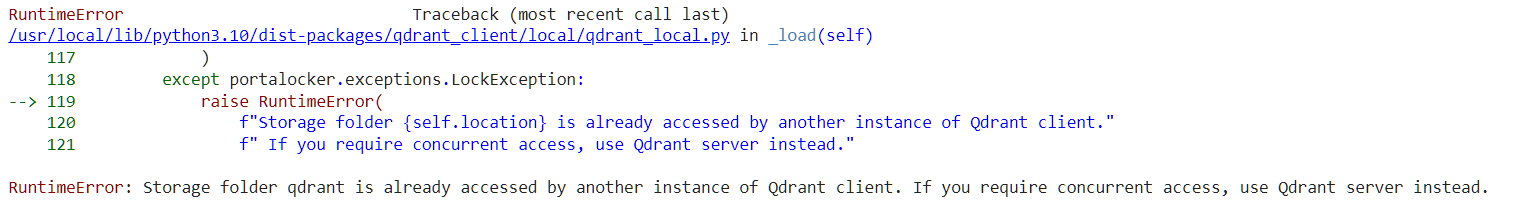

### On the cloud

To use Qdrant on the cloud, you need:
1) The url to your Qdrant cluster
2) An API Key for this specific cluster
To get these, you need to register online here: [https://cloud.qdrant.io](https://cloud.qdrant.io)

In [ ]:
url = "<---qdrant cloud cluster url here --->"
# Make sure that the secret 'QDRANT_API_KEY' exists
api_key = userdata.get('QDRANT_API_KEY')
qdrant = Qdrant.from_documents(
    docs,
    embeddings,
    url=url,
    prefer_grpc=True,
    api_key=api_key,
    collection_name="my_documents",
)

In [ ]:
docs_from_cloud = qdrant.similarity_search(query)
print(docs_from_cloud[0].page_content)

From the day I took office, I have been told that addressing our larger challenges is too ambitious -- that such efforts would be too contentious, that our political system is too gridlocked and that we should just put things on hold for a while.

For those who make these claims, I have one simple question:

How long should we wait? How long should America put its future on hold?


Qdrant allows to use **named vector** and to have different embeddings (dimensions) and search metrics for a point vector. It also allows to add meta-data and filter on these meta-data, which makes it a very complete option.

# LangChain Record Manager

So far, no system is implemented to keep track of the source documents which have been processed and added to a vector store. This part must be added by the application developer.

LangChain has introduced a `RecordManager` class to help do just that. This helps avoiding writing duplicated content to a vector store, re-writing unchanged content, or re-computing embeddings over unchanged content.

The RecordManager keeps track of all the document writes to the vector store, by computing a document hash (`page_content` and `metadata`), and using a source id to allow identifying the ultimate source of the documents.


In [ ]:
%pip install -qU  langchain-qdrant langchain-openai langchain langchain-community

In [ ]:
from langchain.indexes import SQLRecordManager, index
from langchain_core.documents import Document
from langchain_qdrant import QdrantVectorStore
from langchain_openai import OpenAIEmbeddings

from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

collection_name = "test_index"

embeddings = OpenAIEmbeddings(
      model='text-embedding-3-small',
      dimensions=1536,
    )

Create the `QdrantVectorStore`:

In [ ]:
client = QdrantClient(":memory:")

client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=embeddings,
)

Create the `RecordManager`. Note that for the record manager to do his work properly, the vector store must be empty, and all document write must be made through the record manager.

In [ ]:
namespace = f"qdrant_store/{collection_name}"

record_manager = SQLRecordManager(
    namespace, db_url="sqlite:///record_manager_cache.sql"
)
record_manager.create_schema()

Once the record manager is created, the corresponding file appears.

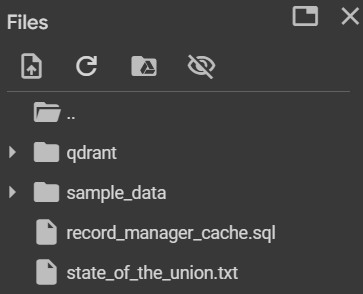

Create the `Document` objects to add. `doc1` and `doc2` come from the same source document (same "source" metadata).

In [ ]:
doc1 = Document(page_content="This is my first chunk of data, coming from document with source id 1234", metadata={"source": "1234"})
doc2 = Document(page_content="This is my second chunk of data, coming from document with source id 1234", metadata={"source": "1234"})
doc3 = Document(page_content="Something else, entirely", metadata={"source": "4321"})

def _clear():
    """Helper method to clear content."""
    index([], record_manager, vector_store, cleanup="full", source_id_key="source")


Make sure that the collection is empty.

In [ ]:
_clear()

print(client.count(collection_name=collection_name).count)

0


We add several identical Document objects. Only 1 is added. No duplication.

In [ ]:
index(
    [doc1, doc1, doc1, doc1, doc1],
    record_manager,
    vector_store,
    cleanup="incremental",
    source_id_key="source",
)

{'num_added': 1, 'num_updated': 0, 'num_skipped': 0, 'num_deleted': 0}

We add two new documents, with replication. Only the new documents are added (`doc2` and `doc3`), the existing document (`doc1`) is skipped.

In [ ]:
index(
    [doc1, doc2, doc2, doc3, doc1],
    record_manager,
    vector_store,
    cleanup="incremental",
    source_id_key="source",
)

{'num_added': 2, 'num_updated': 0, 'num_skipped': 1, 'num_deleted': 0}

We change `doc1`, and keep `doc2`. The old `doc1` is deleted, and the updated one is added.

In [ ]:
changed_doc1 = Document(page_content="This is the updated first chunk of data, coming from document with source id 1234", metadata={"source": "1234"})

In [ ]:
index(
    [doc2, changed_doc1],
    record_manager,
    vector_store,
    cleanup="incremental",
    source_id_key="source",
)

{'num_added': 1, 'num_updated': 0, 'num_skipped': 1, 'num_deleted': 1}

Note that if you do not pass the unchanged chunks for the same source id, they are deleted, as happens below:

In [ ]:
changed_doc2 = Document(page_content="This is the updated second chunk of data, coming from document with source id 1234", metadata={"source": "1234"})

In [ ]:
index(
    [changed_doc2],
    record_manager,
    vector_store,
    cleanup="incremental",
    source_id_key="source",
)

{'num_added': 1, 'num_updated': 0, 'num_skipped': 0, 'num_deleted': 2}

⚡⚡⚡Note that LangChain uses 'indexing' here. It's the same idea as for indexing embeddings, but this indexing happens at a higher level (the level of the source document).


For more information, look at the How_to guide from LangChain here:

https://python.langchain.com/v0.2/docs/how_to/indexing/

# Conclusion

Vectore store, vector database, document store, and index are related concepts, but they come with important
 differences.

 Index refers to the data structure that allow to search efficiently through a set of vectors and returns similar vectors. It does not prescribe nor say anything about how these vectors should be stored, persisted nor even if the corresponding text document should be stored alongside the vectors of embeddings.

Technically, any existing database can be used as a vector store. However, they might not be well equiped to allow for efficient similarity search, as a specialised index is needed for this.

Well known databases such as Postgres and MongoDB have developed add-ons that allow to do just that: create a special vector datatype, and add the required functionalities to create and maintain an index that allows for easier storage and retrieval of embeddings and their corresponding text.

[MongoDB Atlas with LangChain](https://python.langchain.com/v0.2/docs/integrations/vectorstores/mongodb_atlas/)

[PGVector, Postgres Vector Database](https://python.langchain.com/v0.2/docs/integrations/vectorstores/pgvector/)